In [90]:
# 参考資料(https://qiita.com/fujin/items/7f0a7b6fc8fb662f510d)
# 回帰（重回帰(リッジ回帰)、Lasso回帰、ElasticNet回帰）
# 重回帰分析(リッジ回帰)→カーネルなしSVR→ガウンシアンカーネルのSVRで予測精度を比較

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import sys
sys.path.append('/home/yoshida/.pyenv/versions/3.6.6/lib/python3.6/site-packages')
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score # R^2(決定係数)のスコアを出力
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split # データをトレーニング用とテスト用に分割するためのライブラリ
from sklearn.metrics import mean_squared_error # MSE
from sklearn.metrics import mean_absolute_error # MAE
from sklearn.preprocessing import StandardScaler # 標準化
from sklearn.linear_model import Ridge # リッジ回帰
from sklearn.linear_model import Lasso # Lasso回帰
from sklearn.linear_model import ElasticNet # ElasticNet
from sklearn.model_selection import GridSearchCV # グリッドサーチ
from sklearn.svm import SVR # SVR差がないように思える

In [91]:
boston = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data', header=None, sep='\s+')
#「sep = \s+」は、もとのデータの区切りがスペースであり、スペースが複数個続いていることを示している
boston.columns = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PIRATIO','B','LSTAT','MEDV']
#カラムの名前を指定
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PIRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [92]:
# 回帰のグラフがトレーニングデータにどれだけ適合しているのかを可視化する「lin_regplot関数」を定義する
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)
    return

In [115]:
X = boston.loc[:,['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PIRATIO', 'B', 'LSTAT']] # 特徴量
y = boston['MEDV'].values # 目的変数


# トレーニング・テストデータ分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=114514)

# まず、重回帰分析でどの程度精度が出るかを見てみる
# 変数は特に削らずに、標準化したものすべてを使う。正則化も行なうため、リッジ回帰を使う
# したがって、交差検証で最適化するハイパーパラメータは、正則化のα1つだけ。
# 重回帰自体が正規方程式で解けるし、ハイパーパラメータが少ないから、めっちゃ計算早い

# 6:2:2に分割するため、訓練データのうちの後ろ1/4を交差検証データとする
# 交差検証データのジェネレータ
def gen_cv():
    m_train = np.floor(len(y_train)*0.75).astype(int) # このキャストをintにしないと後にハマる
    train_indices = np.arange(m_train)
    test_indices = np.arange(m_train, len(y_train))
    yield (train_indices, test_indices) # それぞれ(303 101 102 = サンプル合計は506)

print("リッジ回帰")
print()
print("訓練データ、交差検証データ、テストデータの数 = ", end="")
print(len(next(gen_cv())[0]), len(next(gen_cv())[1]), len(y_test) )
print()

リッジ回帰

訓練データ、交差検証データ、テストデータの数 = 303 101 102



In [117]:
# SVRでは標準化が重要となるため、ここで標準化
# StandardScalerで「(X-平均)/標準偏差」の標準化を行なう

# 訓練データを基準に標準化(平均、標準偏差で標準化)
scaler = StandardScaler()
X_norm = scaler.fit_transform(X_train)

# テストデータも標準化
X_test_norm = scaler.transform(X_test)

# ここでポイントなのが、訓練データの平均分散を基準にして、テストデータを標準化すること。
# 訓練データは、fit_transform、テストデータはtransformで計算する

# （＊）

/home/yoshida/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/yoshida/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/yoshida/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


In [118]:
# 次に正則化のハイパーパラメータαをチューニングする。Sckit-learn組み込みのGridSearchCVを使うと便利

# ハイパーパラメータのチューニング
params = {"alpha":np.logspace(-2, 4, 24)} # -2から4まで24個のデータをランダムに
gridsearch = GridSearchCV(Ridge(), params, cv=gen_cv(), scoring="r2", return_train_score=True)
gridsearch.fit(X_norm, y_train)
print("αのチューニング")
print("最適なパラメーター =", gridsearch.best_params_, "精度 =", gridsearch.best_score_)
print()

αのチューニング
最適なパラメーター = {'alpha': 149.2495545051829} 精度 = 0.690669026120447



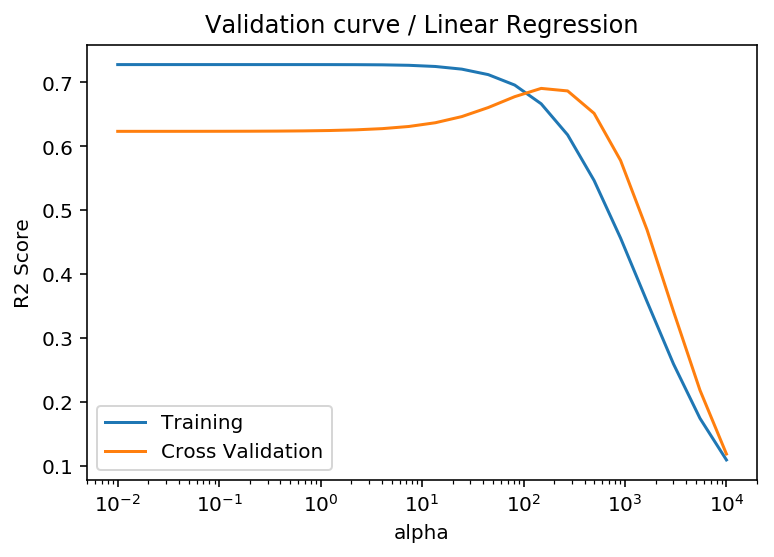

In [119]:
# 検証曲線
plt.semilogx(params["alpha"], gridsearch.cv_results_["mean_train_score"], label="Training")
plt.semilogx(params["alpha"], gridsearch.cv_results_["mean_test_score"], label="Cross Validation")
plt.xlabel("alpha")
plt.ylabel("R2 Score")
plt.title("Validation curve / Linear Regression")
plt.legend()
plt.show()

In [120]:
# αが10^2(=149.+)で、CVの精度(決定係数)が最大化されることがわかった
# コンソールに出ている「gridsearch.best_score_」は交差検証データに対する決定係数である

In [121]:
# チューニングしたαでフィットさせ、テストデータに対する精度を求める
regr = Ridge(alpha=gridsearch.best_params_["alpha"])
train_indices = next(gen_cv())[0]
valid_indices = next(gen_cv())[1]
regr.fit(X_norm[train_indices, :], y_train[train_indices])
print("切片と係数")
print(regr.intercept_)
print(regr.coef_)
print()
# テストデータの精度を計算
print("テストデータにフィット")
print("テストデータの精度 =", regr.score(X_test_norm, y_test))
print()
print("※参考")
print("訓練データの精度 =", regr.score(X_norm[train_indices, :], y_train[train_indices]))
print("交差検証データの精度 =", regr.score(X_norm[valid_indices, :], y_train[valid_indices]))

切片と係数
22.893123943264335
[-0.46861415  0.51249514 -0.34423964  0.94872619 -0.55980061  2.44810234
 -0.08502659 -1.08996542  0.48912441 -0.35540356 -1.38785068  0.60844346
 -2.86197237]

テストデータにフィット
テストデータの精度 = 0.7713515272238126

※参考
訓練データの精度 = 0.6666027990264252
交差検証データの精度 = 0.690669026120447


In [122]:
# 次は、カーネルなし(線形カーネル)のSVR (＊)まではリッジ回帰と同じ
# 分類問題で使うSVMはカーネルなしなら、ハイパーパラメータは正則化のCだけでOKである
# 回帰で使用するSVRは、線形カーネルでも正則化のCの他にεという(別名：誤差のチューブ)ハイパーパラメータが必要
# したがって、2次元のハイパーパラメータの最適化を行なう必要がある

# ハイパーパラメータのチューニング
# 計算に時間がかるため、ある程度パラメータを絞る

params_cnt = 20
params = {"C":np.logspace(0,1,params_cnt), "epsilon":np.logspace(-1,1,params_cnt)}
gridsearch = GridSearchCV(SVR(kernel="linear"), params, cv=gen_cv(), scoring="r2", return_train_score=True)
gridsearch.fit(X_norm, y_train)
print("C, εのチューニング")
print("最適なパラメーター =", gridsearch.best_params_)
print("精度 =", gridsearch.best_score_)
print()

# グリッドサーチ(総当り)で試すと次元数のべき乗で試行回数が増えていく(今回は2乗)ので、
# 予め大きめの区切りで調べてから解がどのへんにあるかを見当つけてから、細かい区切りで調べていったほうが効率よさげ
# 結果を見ると、重回帰分析とそんなに差がないように思える

C, εのチューニング
最適なパラメーター = {'C': 5.455594781168519, 'epsilon': 0.42813323987193935}
精度 = 0.7159704111799419



In [123]:
# チューニングしたハイパーパラメーターをフィット
regr = SVR(kernel="linear", C=gridsearch.best_params_["C"], epsilon=gridsearch.best_params_["epsilon"])
train_indices = next(gen_cv())[0]
valid_indices = next(gen_cv())[1]
regr.fit(X_norm[train_indices, :], y_train[train_indices])
print("切片と係数")
print(regr.intercept_)
print(regr.coef_)
print()
# テストデータの精度を計算
print("テストデータにフィット")
print("テストデータの精度 =", regr.score(X_test_norm, y_test))
print()
print("※参考")
print("訓練データの精度 =", regr.score(X_norm[train_indices, :], y_train[train_indices]))
print("交差検証データの精度 =", regr.score(X_norm[valid_indices, :], y_train[valid_indices]))

切片と係数
[21.81552321]
[[-0.92397204  0.86508237  0.21502723  0.41965102 -1.09456985  3.61738556
  -0.57089419 -1.88129657  1.72834405 -1.61423868 -1.76378538  0.72248999
  -2.69561026]]

テストデータにフィット
テストデータの精度 = 0.8340448426009677

※参考
訓練データの精度 = 0.6756997065869151
交差検証データの精度 = 0.7159704111799418


In [124]:
# 切片と係数は重回帰と似たりよったりな感じ。なので、カーネルなしSVRは重回帰にちょっと毛が生えた程度。
# カーネルなしのSVRでは、テストデータに対する決定係数は、0.828となった。
# 訓練、交差検証、テストのどのデータに対しても重回帰よりは若干決定係数が上がっていることが確認できる

In [125]:
# 次は、ガウンシアンカーネルを使ったサポートベクター回帰(SVR)で予測をする。
# サポートベクターマシン(SVM)のガウンシアンカーネルを使った場合のハイパーパラメータは、正則化のCとΥだったが、
# SVRの場合は、誤差のεを含めて3つになる
# ここでは計算の簡略化のために、似たような意味合いを持つCとΥのうち、Υを固定。Scikit-learnでもデフォルトで
# Υを指定しなければ、オートとしてΥ=1/変数の数と計算する。ライブラリ側から「CとΥが似たようなパラメータだから
# Cだけ調整すればだいたいよくね？」というありがたい提案である。
# もちろん、Υもちゃんと計算したほうが精度はより良くなるはずだが、グリッドサーチの量が2乗から3乗は・・・笑
# そのため、ここではΥをデフォルトの「auto」としている。
# ほぼ、カーネルなしのSVRのときと変わらない(SVRの引数のkernelが変わっただけ)

def gen_cv():
    m_train = np.floor(len(y_train)*0.75).astype(int) # このキャストをintにしないと後にハマる
    train_indices = np.arange(m_train)
    test_indices = np.arange(m_train, len(y_train))
    yield (train_indices, test_indices) # それぞれ(354 152 152 = サンプル合計は506)

ガウシアンカーネルのSVR



/home/yoshida/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/yoshida/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/yoshida/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
/home/yoshida/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yoshida/anaconda3/lib/python3.

/home/yoshida/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yoshida/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yoshida/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yoshida/anaconda3/lib/python3.6/site-packages/

/home/yoshida/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yoshida/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yoshida/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yoshida/anaconda3/lib/python3.6/site-packages/

/home/yoshida/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yoshida/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yoshida/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yoshida/anaconda3/lib/python3.6/site-packages/

/home/yoshida/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yoshida/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yoshida/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yoshida/anaconda3/lib/python3.6/site-packages/

/home/yoshida/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yoshida/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yoshida/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yoshida/anaconda3/lib/python3.6/site-packages/

/home/yoshida/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yoshida/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yoshida/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yoshida/anaconda3/lib/python3.6/site-packages/

/home/yoshida/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yoshida/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yoshida/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yoshida/anaconda3/lib/python3.6/site-packages/

/home/yoshida/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yoshida/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yoshida/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yoshida/anaconda3/lib/python3.6/site-packages/

/home/yoshida/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yoshida/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yoshida/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yoshida/anaconda3/lib/python3.6/site-packages/

/home/yoshida/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yoshida/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yoshida/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yoshida/anaconda3/lib/python3.6/site-packages/

/home/yoshida/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yoshida/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yoshida/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yoshida/anaconda3/lib/python3.6/site-packages/

C, εのチューニング
最適なパラメーター = {'C': 18.329807108324356, 'epsilon': 1.438449888287663}
精度 = 0.8697986963341774



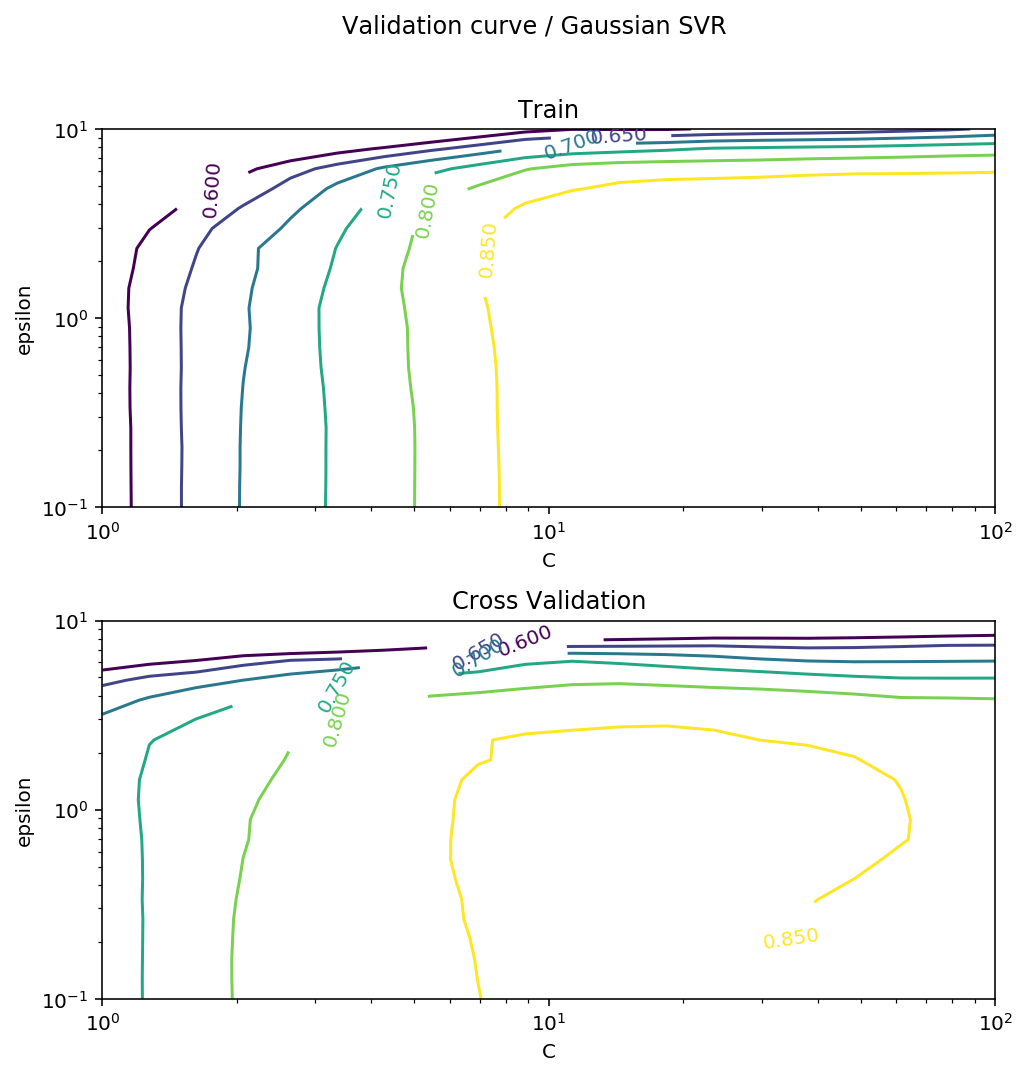

テストデータにフィット
テストデータの精度 = 0.9078764106569381

※参考
訓練データの精度 = 0.9196007804147397
交差検証データの精度 = 0.8697986963341774


/home/yoshida/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [126]:
def gen_cv():
    m_train = np.floor(len(y_train)*0.75).astype(int)#このキャストをintにしないと後にハマる
    # yの訓練データの数に3/4をかけて四捨五入し、整数化
    train_indices = np.arange(m_train) # 0からm_train-1までの配列を作る
    test_indices = np.arange(m_train, len(y_train)) # m_trainからlen(y)-1の配列を作る
    yield (train_indices, test_indices) # (それぞれ303 101 102 = サンプル合計は506)

print("ガウシアンカーネルのSVR")
print()

# 訓練データを基準に標準化（平均、標準偏差で標準化）
scaler = StandardScaler()
X_norm = scaler.fit_transform(X_train)
# テストデータも標準化
X_test_norm = scaler.transform(X_test)

# ハイパーパラメータのチューニング
params_cnt = 20
params = {"C":np.logspace(0,2,params_cnt), "epsilon":np.logspace(-1,1,params_cnt)}
gridsearch = GridSearchCV(SVR(), params, cv=gen_cv(), scoring="r2", return_train_score=True)
gridsearch.fit(X_norm, y_train)
print("C, εのチューニング")
print("最適なパラメーター =", gridsearch.best_params_)
print("精度 =", gridsearch.best_score_)
print()

# 検証曲線
plt_x, plt_y = np.meshgrid(params["C"], params["epsilon"])
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(hspace = 0.3)
for i in range(2):
    if i==0:
        plt_z = np.array(gridsearch.cv_results_["mean_train_score"]).reshape(params_cnt, params_cnt, order="F")
        title = "Train"
    else:
        plt_z = np.array(gridsearch.cv_results_["mean_test_score"]).reshape(params_cnt, params_cnt, order="F")
        title = "Cross Validation"
    ax = fig.add_subplot(2, 1, i+1)
    CS = ax.contour(plt_x, plt_y, plt_z, levels=[0.6, 0.65, 0.7, 0.75, 0.8, 0.85])
    ax.clabel(CS, CS.levels, inline=True)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("C")
    ax.set_ylabel("epsilon")
    ax.set_title(title)
plt.suptitle("Validation curve / Gaussian SVR")
plt.show()

# チューニングしたC,εでフィット
regr = SVR(C=gridsearch.best_params_["C"], epsilon=gridsearch.best_params_["epsilon"])
train_indices = next(gen_cv())[0]
valid_indices = next(gen_cv())[1]
regr.fit(X_norm[train_indices, :], y_train[train_indices])
# テストデータの精度を計算
print("テストデータにフィット")
print("テストデータの精度 =", regr.score(X_test_norm, y_test))
print()
print("※参考")
print("訓練データの精度 =", regr.score(X_norm[train_indices, :], y_train[train_indices]))
print("交差検証データの精度 =", regr.score(X_norm[valid_indices, :], y_train[valid_indices]))